# Fish price prediction for Fishku company-based capstone project
This notebook is the development code for fish price prediction by **Torani Team (C23-OS02)**

In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [ ]:
# Import Data
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
pd.set_option('display.max_columns', None)

gc = gspread.authorize(creds)

# Import data tongkol abu
wb_tongkol_abu= gc.open_by_key('1wfDYsxeOTqnroxiecTK-z-ThcBXTEnMz40bbiLtnB18').sheet1
rows_tongkol_abu = wb_tongkol_abu.get_all_values()
df_tongkol_abu = pd.DataFrame.from_records(rows_tongkol_abu)
df_tongkol_abu.columns = pd.RangeIndex(df_tongkol_abu.columns.size)
df_tongkol_abu = df_tongkol_abu.set_axis(df_tongkol_abu.iloc[0], axis=1).drop(0)
df_tongkol_abu['harga']=df_tongkol_abu['harga'].astype(float)

# Preparation for neural network

In [ ]:
# Normalize the data
max_tongkol_abu=max(df_tongkol_abu['harga'])
min_tongkol_abu=min(df_tongkol_abu['harga'])
df_tongkol_abu['harga']=scaler.fit_transform(np.array(df_tongkol_abu['harga']).reshape(-1,1))

In [ ]:
# Write function to split the dataset
def train_val_split( series, split_time):
    series_train = series[:split_time]
    series_valid = series[split_time:]
    return series_train, series_valid


# Split the dataset
tongkol_series_train, tongkol_series_valid = train_val_split(series=df_tongkol_abu, split_time=int(0.8*len(df_tongkol_abu)))

In [ ]:
# Windowing the data set

# X: [[[1], [2], [3], [4], [5]]] Y:[6]
# X: [[[2], [3], [4], [5], [6]]] Y:[7]
# X: [[[3], [4], [5], [6], [7]]] Y:[8]

def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X, dtype=float), np.array(y, dtype=float)

#window the trainin and validation dataset
tongkol_train_set,tongkol_train_label = df_to_X_y(tongkol_series_train['harga'],window_size=8)
tongkol_valid_set,tongkol_valid_label = df_to_X_y(tongkol_series_valid['harga'],window_size=8)

# Model 1: RNN

In [ ]:
# RNN model for price prediction
model_rnn = tf.keras.models.Sequential([ 
            tf.keras.layers.Conv1D(filters=4, kernel_size=2,
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
            tf.keras.layers.SimpleRNN(16, return_sequences=True),
            tf.keras.layers.SimpleRNN(16),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dense(1)])
    
# Compile the model passing in the appropriate loss
model_rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 4)           12        
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          336       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,293
Trainable params: 1,293
Non-trainabl

In [ ]:
# Train the RNN model
history_rnn=model_rnn.fit(tongkol_train_set, tongkol_train_label, validation_data=(tongkol_valid_set,tongkol_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 7s 82ms/step - loss: 0.0435 - mae: 0.2169 - val_loss: 0.0091 - val_mae: 0.1230
Epoch 2/500
8/8 [==============================] - 0s 24ms/step - loss: 0.0117 - mae: 0.1253 - val_loss: 0.0019 - val_mae: 0.0462
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0086 - mae: 0.0987 - val_loss: 0.0021 - val_mae: 0.0498
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0062 - mae: 0.0901 - val_loss: 0.0018 - val_mae: 0.0471
Epoch 5/500
8/8 [==============================] - 0s 22ms/step - loss: 0.0045 - mae: 0.0717 - val_loss: 0.0015 - val_mae: 0.0425
Epoch 6/500
8/8 [==============================] - 0s 23ms/step - loss: 0.0037 - mae: 0.0692 - val_loss: 0.0015 - val_mae: 0.0424
Epoch 7/500
8/8 [==============================] - 0s 26ms/step - loss: 0.0029 - mae: 0.0583 - val_loss: 0.0017 - val_mae: 0.0437
Epoch 8/500
8/8 [==============================] - 0s 27ms/step - loss: 0.0028 - mae: 0.05

In [ ]:
# Evaluate the trained model
model_rnn.evaluate(tongkol_valid_set,tongkol_valid_label, batch_size=50)

2/2 [==============================] - 0s 28ms/step - loss: 1.1758e-04 - mae: 0.0119


[0.00011758237087633461, 0.011937432922422886]

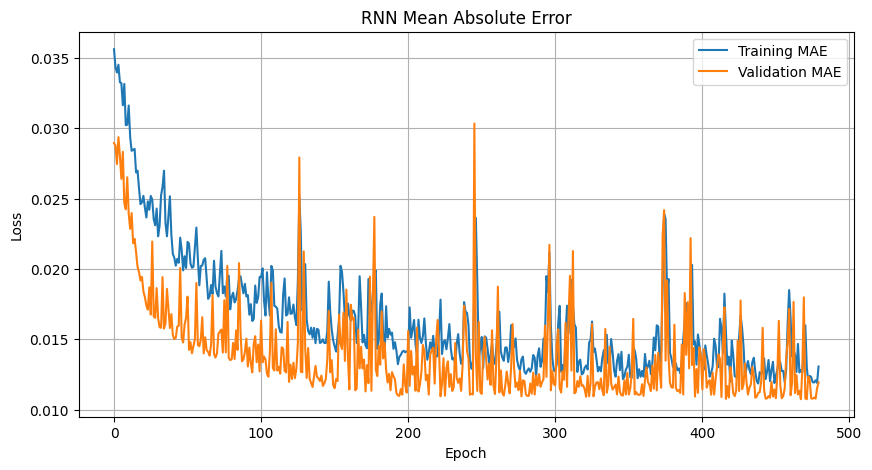

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_rnn.history['mae'][20:],label='Training MAE')
plt.plot(history_rnn.history['val_mae'][20:],label='Validation MAE')
plt.title('RNN Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

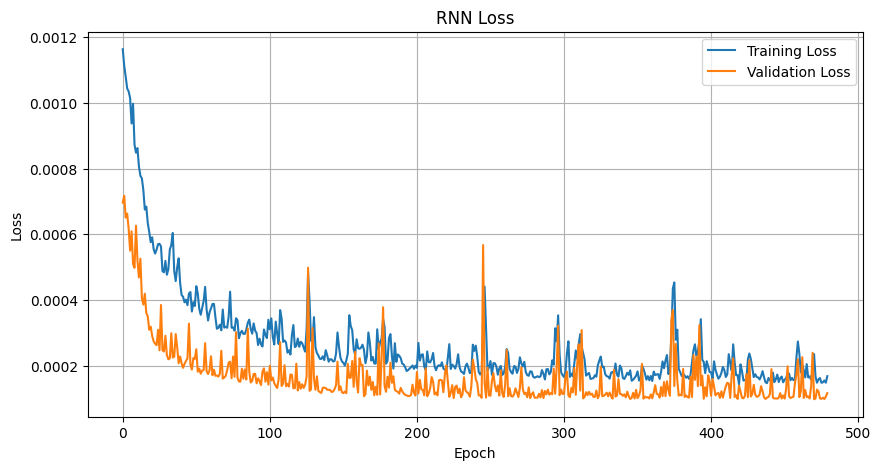

In [ ]:
# Plot the loss of RNN model
plt.figure(figsize=(10, 5))
plt.plot(history_rnn.history['loss'][20:],label='Training Loss')
plt.plot(history_rnn.history['val_loss'][20:],label='Validation Loss')
plt.title('RNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

2/2 [==============================] - 0s 7ms/step


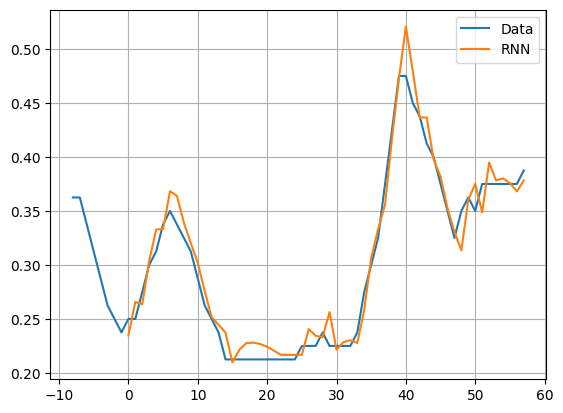

In [ ]:
# Plot the predicted price and real data
redicted_tongkol_abu=model_rnn.predict(tongkol_valid_set)

plt.plot(np.arange(len(tongkol_series_valid))-8,tongkol_series_valid['harga'],label='Data')
plt.plot(np.arange(len(predicted_tongkol_abu)),predicted_tongkol_abu,label='RNN')
plt.grid()
plt.legend()

# Model 2: LSTM

In [ ]:
# LSTM model for fish price prediction
model_lstm = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2, # Masih perlu di tune
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1),
             tf.keras.layers.Lambda(lambda x: x * 34.66)]) # Masih perlu di tune

# Compile the model passing in the appropriate loss
model_lstm.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 4)           12        
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         2688      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
# Train the model
history_lstm=model_lstm.fit(tongkol_train_set, tongkol_train_label, validation_data=(tongkol_valid_set,tongkol_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 11s 205ms/step - loss: 0.4677 - mae: 0.8617 - val_loss: 0.0281 - val_mae: 0.2187
Epoch 2/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0334 - mae: 0.2021 - val_loss: 0.0365 - val_mae: 0.2638
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 0.0150 - mae: 0.1492 - val_loss: 5.6645e-04 - val_mae: 0.0271
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0095 - mae: 0.1082 - val_loss: 0.0080 - val_mae: 0.1195
Epoch 5/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0041 - mae: 0.0735 - val_loss: 0.0022 - val_mae: 0.0472
Epoch 6/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0038 - mae: 0.0704 - val_loss: 8.3747e-04 - val_mae: 0.0341
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0509 - val_loss: 7.0095e-04 - val_mae: 0.0331
Epoch 8/500
8/8 [==============================] - 0s 14ms/step - loss: 0.00

In [ ]:
# Evaluate the training process
model_lstm.evaluate(tongkol_valid_set,tongkol_valid_label, batch_size=50)

2/2 [==============================] - 0s 11ms/step - loss: 1.2635e-04 - mae: 0.0116


[0.00012634599988814443, 0.011596259661018848]

2/2 [==============================] - 0s 7ms/step


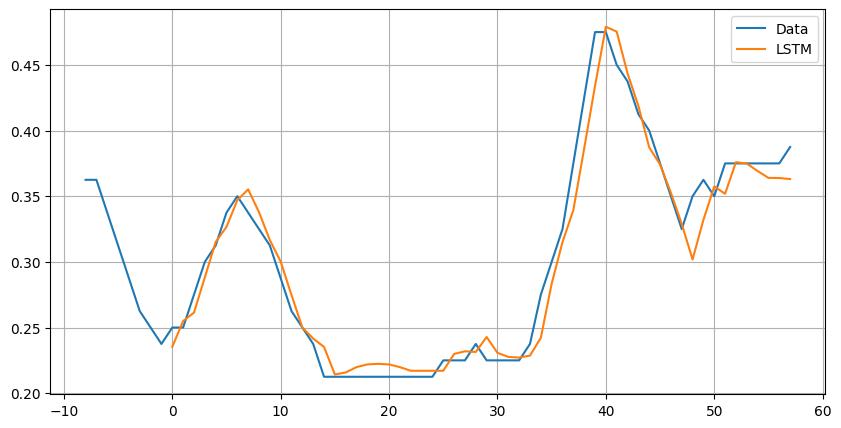

In [ ]:
# Plot the fish price prediction and the real data
predicted_tongkol_abu_LSTM=model_lstm.predict(tongkol_valid_set)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(tongkol_series_valid))-8,tongkol_series_valid['harga'],label='Data')
plt.plot(np.arange(len(predicted_tongkol_abu_LSTM)),predicted_tongkol_abu_LSTM,label='LSTM')
plt.grid()
plt.legend()

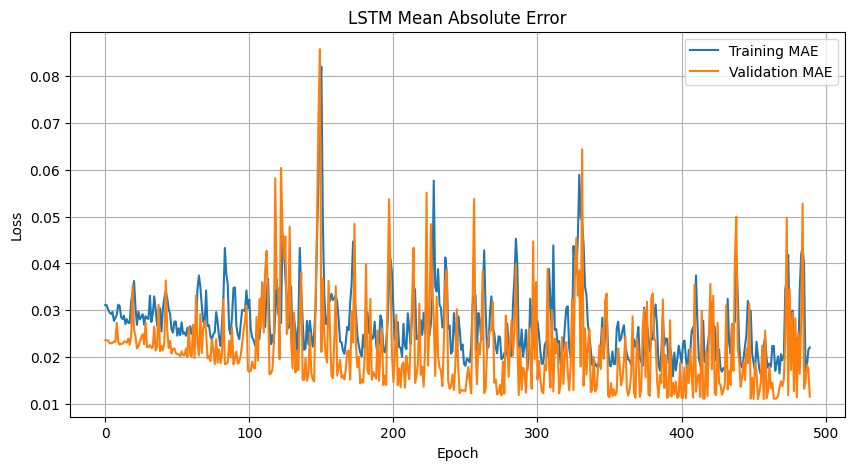

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['mae'][10:],label='Training MAE')
plt.plot(history_lstm.history['val_mae'][10:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

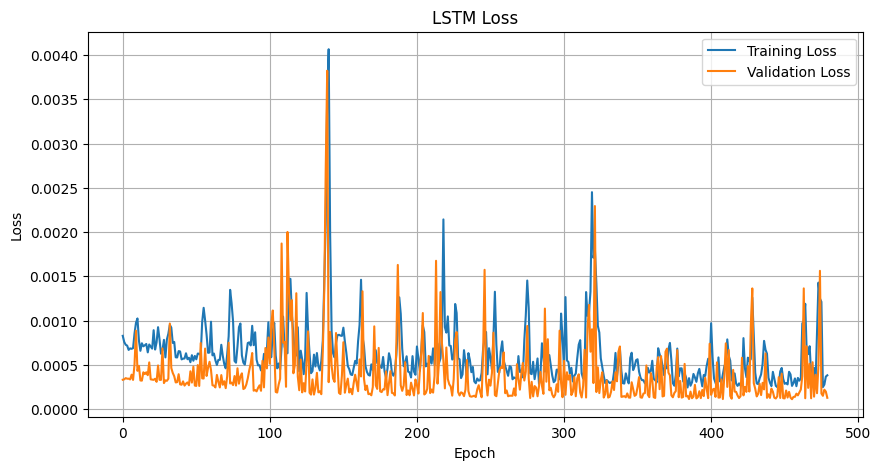

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'][10:],label='Training Loss')
plt.plot(history_lstm.history['val_loss'][10:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Model Comparison: LSTM vs RNN

In [ ]:
# Compare the loss and mae of the RNN and LSTM model
print("LSTM:")
model_lstm.evaluate(tongkol_valid_set,tongkol_valid_label, batch_size=100)

print("RNN:")
model_rnn.evaluate(tongkol_valid_set,tongkol_valid_label, batch_size=100)

LSTM:
1/1 [==============================] - 0s 28ms/step - loss: 1.2635e-04 - mae: 0.0116
RNN:
1/1 [==============================] - 0s 26ms/step - loss: 1.1758e-04 - mae: 0.0119


[0.00011758231994463131, 0.011937437579035759]

In [ ]:
#Predict the validation data

predicted_tongkol_abu=model_rnn.predict(tongkol_valid_set)
predicted_tongkol_abu_LSTM=model_lstm.predict(tongkol_valid_set)

2/2 [==============================] - 0s 7ms/step


In [ ]:
#Unnormalize the data

tongkol_series_valid['harga']=(tongkol_series_valid['harga']*(max_tongkol_abu-min_tongkol_abu))+min_tongkol_abu
predicted_tongkol_abu=(predicted_tongkol_abu*(max_tongkol_abu-min_tongkol_abu))+min_tongkol_abu
predicted_tongkol_abu_LSTM=(predicted_tongkol_abu_LSTM*(max_tongkol_abu-min_tongkol_abu))+min_tongkol_abu

In [ ]:
# Compare the MAE of both model in Rp/kg
from sklearn.metrics import mean_absolute_error

mae_rnn=mean_absolute_error(tongkol_series_valid['harga'][:-8],predicted_tongkol_abu)
mae_lstm=mean_absolute_error(tongkol_series_valid['harga'][:-8],predicted_tongkol_abu_LSTM)

print('RNN Mean Absolute Error:','Rp',mae_rnn,)
print('LSTM Mean Absolute Error:','Rp',mae_lstm)

RNN Mean Absolute Error: Rp 361.22743803879365
LSTM Mean Absolute Error: Rp 343.06701239224196


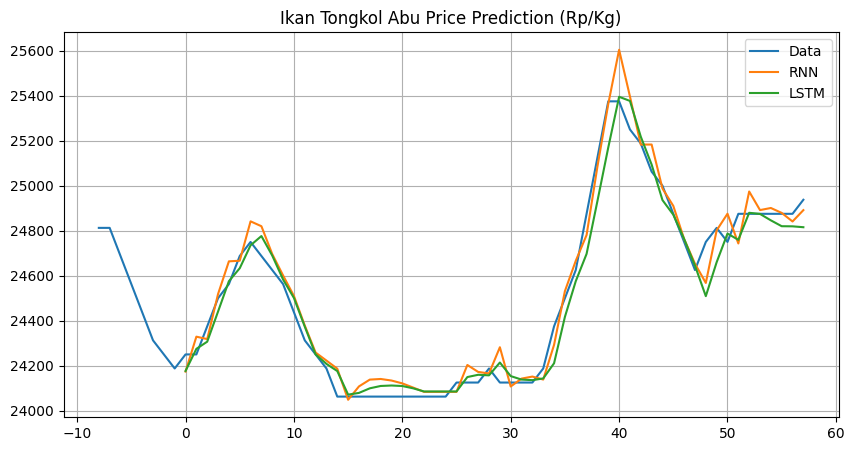

In [ ]:
#Plot the figure

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(tongkol_series_valid))-8,tongkol_series_valid['harga'],label='Data')
plt.plot(np.arange(len(predicted_tongkol_abu)),predicted_tongkol_abu,label='RNN')
plt.plot(np.arange(len(predicted_tongkol_abu_LSTM)),predicted_tongkol_abu_LSTM,label='LSTM')
plt.title('Ikan Tongkol Abu Price Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot the figure using Plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(tongkol_series_valid))-7, y=tongkol_series_valid['harga'], name='Data'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_tongkol_abu)), y=predicted_tongkol_abu.flatten(), name='RNN'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_tongkol_abu_LSTM)), y=predicted_tongkol_abu_LSTM.flatten(), name='LSTM'))
fig.update_layout(title='Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()
